<a href="https://colab.research.google.com/github/seeverblog/BCDU-Ne/blob/master/RESNET_50_DATA_PREPROCESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
os.chdir('/content/drive/My Drive/Colab Notebooks/DATA RD/')
files = glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATA_PREPROCESSING/*')

len (files)

7200

In [4]:
train_imgs = [fn for fn in files]
len(train_imgs)

7200

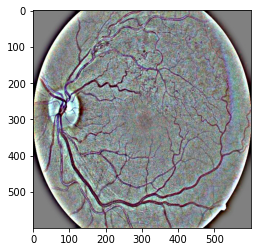

In [5]:
import matplotlib.image as mpimg
for ima in train_imgs[0:1]:
     img=mpimg.imread(ima)
     imgplot = plt.imshow(img)
     plt.show()

In [0]:
nrows = 312
ncolumns = 312
channels = 3  

def read_and_process_image(list_of_images):
    
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels
        if 'Normal' in image:
            y.append(0)
        elif 'Mild' in image:
            y.append(1)
        elif 'Moderate' in image:
            y.append(2)
        elif 'Severe' in image:
            y.append(3)

    
    return X, y

In [0]:
X, y = read_and_process_image(train_imgs)

Text(0.5, 1.0, 'Total images of each class')

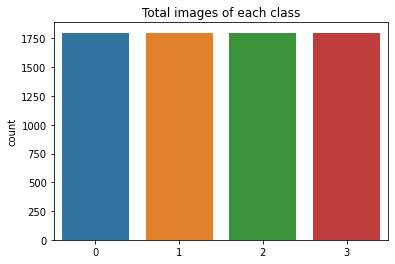

In [8]:
import seaborn as sns
import gc 
gc.collect()

#Convert list to numpy array
X = np.array(X)
y = np.array(y)

#Lets plot the label to be sure we just have two class
sns.countplot(y)
plt.title('Total images of each class')

In [9]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (7200, 312, 312, 3)
Shape of labels is: (7200,)


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=np.array(y),random_state=2)

In [11]:
print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (5760, 312, 312, 3)
Shape of validation images is: (1440, 312, 312, 3)
Shape of labels is: (5760,)
Shape of labels is: (1440,)


In [0]:
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32

In [13]:
y_train_ohe = pd.get_dummies(y_train)
y_val_ohe=pd.get_dummies(y_val)

y_train_ohe.shape,y_val_ohe.shape

((5760, 4), (1440, 4))

In [0]:
BATCH_SIZE = 32
EPOCHS = 30
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 312
WIDTH = 312
CANAL = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [17]:
IMG_SHAPE = (312, 312, 3)
base_model =tf.keras.applications.ResNet50(weights='imagenet', 
                                       include_top=False,
                                       input_shape=IMG_SHAPE)
x =tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x =tf.keras.layers.Dropout(0.5)(x)
x =tf.keras.layers.Dense(2048, activation='relu')(x)
x =tf.keras.layers.Dropout(0.5)(x)
final_output =tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='final_output')(x)
model =tf.keras.models.Model(inputs=base_model.inputs,outputs=final_output)

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True


In [0]:
metric_list = ["accuracy"]
optimizer =tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)

In [0]:
train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                 zoom_range=[0.9, 1.1],
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [0]:
train_generator = train_datagen.flow(X_train, y_train_ohe, batch_size=batch_size)
val_generator = train_datagen.flow(X_val, y_val_ohe, batch_size=batch_size)

In [22]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=WARMUP_EPOCHS,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
180/180 [==============================] - 146s 813ms/step - loss: 1.6685 - accuracy: 0.3160 - val_loss: 1.3012 - val_accuracy: 0.3938
Epoch 2/2
180/180 [==============================] - 144s 800ms/step - loss: 1.3441 - accuracy: 0.3472 - val_loss: 1.2783 - val_accuracy: 0.3938


In [0]:
for layer in model.layers:
  layer.trainable = True

es =tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)

In [0]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

In [25]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=val_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/30
180/180 [==============================] - 148s 822ms/step - loss: 1.0422 - accuracy: 0.5434 - val_loss: 1.5197 - val_accuracy: 0.2549 - lr: 1.0000e-04
Epoch 2/30
180/180 [==============================] - 145s 805ms/step - loss: 0.8906 - accuracy: 0.6337 - val_loss: 3.9141 - val_accuracy: 0.2431 - lr: 1.0000e-04
Epoch 3/30
180/180 [==============================] - 144s 799ms/step - loss: 0.8338 - accuracy: 0.6398 - val_loss: 1.6600 - val_accuracy: 0.2694 - lr: 1.0000e-04
Epoch 4/30
180/180 [==============================] - ETA: 0s - loss: 0.7913 - accuracy: 0.6661
Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
180/180 [==============================] - 143s 797ms/step - loss: 0.7913 - accuracy: 0.6661 - val_loss: 1.8337 - val_accuracy: 0.3278 - lr: 1.0000e-04
Epoch 5/30
180/180 [==============================] - 143s 794ms/step - loss: 0.7056 - accuracy: 0.7010 - val_loss: 1.9641 - val_accuracy: 0.4743 - lr: 5.0000e-05
Epoch 6/30
180/180 [